# an emission spectrum  check CO



In [1]:
#
#   Current Status: Feb. 23th (2021)
#
#   OK: forward JVP / HML RT alpha as a free parameter
#   Not work: primitive backward / alpha as a free parameter
#   Not implemented yet: VJP backward (something wrong for NumPyro) 
#
#   Current fiducial model: forward JVP
#   Updates: 1st sanity check with petit (Feb.23/2021)
#
#   ToDo:
#   Q(T) TIPS
# 

In [2]:
# importing lpf modile in exojax.spec
%load_ext autoreload
%autoreload 2
from exojax.spec import rtransfer as rt
from exojax.spec import planck
from exojax.spec import moldb
from exojax.spec import make_numatrix0,xsvector
from exojax.spec.lpf import xsmatrix
from exojax.spec.clpf import cxsmatrix
from exojax.spec.hitran import SijT, doppler_sigma, gamma_hitran, gamma_natural
from exojax.plot.atmplot import plottau, plotcf
from exojax.spec.rtransfer import rtrun 
import numpy as np
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

/home/kawahara/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import jax.numpy as jnp
from jax import random
from jax import vmap, jit
plt.style.use('bmh')

## INPUT MODEL

In [26]:
N=1400
wav=np.linspace(22945,23055,N,dtype=np.float64)#AA
nus=1.e8/wav[::-1]

alpha_in=0.02
NP=100
Parr, dParr, k=rt.pressure_layer(NP=NP)
Tarr = 1500.*(Parr/Parr[-1])**alpha_in

#loading molecular database (HITRAN2012/CO)
mdbCO=moldb.MdbHit('/home/kawahara/exojax/data/CO/05_hit12.par',nus)
#mdbCO=moldb.MdbHit('/home/kawahara/exojax/data/hitemp/CO/05_HITEMP2010.par',nus)
#mdbCO=moldb.MdbHit('/home/kawahara/exojax/data/hitemp/CO/05_HITEMP2019.par',nus)

In [29]:
nus[1]-nus[0]

0.014792657388170483

In [30]:
from exojax.utils.chopstacks import buildwall 
wParr=buildwall(Parr)
dParr=wParr[1:]-wParr[0:-1]

In [31]:
#partition function ratio
#mdbCO_HITRAN=moldb.MdbHit('/home/kawahara/exojax/data/CO','05_hit12',nus)
mdbCO_hitran=moldb.MdbHit('/home/kawahara/exojax/data/CO/05_hit12.par',nus)
qt=mdbCO_hitran.Qr_layer(Tarr)

In [32]:
from scipy.constants import  m_u
mmw=2.33 #mean molecular weight
molmass=28.01 #molecular mass
mmr=0.01 #mass mixing ratio

g=1.e5 # gravity cm/s2
Xco=np.ones_like(Tarr)*mmr*mmw/molmass #volume mixing ratio
tfac=1.e3*Xco/(mmw*m_u*g)  

In [33]:
SijM=vmap(SijT,(0,None,None,None,0))(Tarr,mdbCO.logsij0,mdbCO.nu_lines\
                                          ,mdbCO.elower,qt)
gammaLM = vmap(gamma_hitran,(0,0,0,None,None,None))\
(Parr,Tarr,Parr*Xco, mdbCO.n_air, mdbCO.gamma_air, mdbCO.gamma_self)
+ gamma_natural(mdbCO.A) #uncomment if you inclide a natural width
sigmaDM=vmap(doppler_sigma,(None,0,None))(mdbCO.nu_lines,Tarr,molmass)

In [34]:
nu0=mdbCO.nu_lines
numatrix=make_numatrix0(nus,nu0)
xsm=xsmatrix(numatrix,sigmaDM,gammaLM,SijM)

## cheking d tau and contribution function

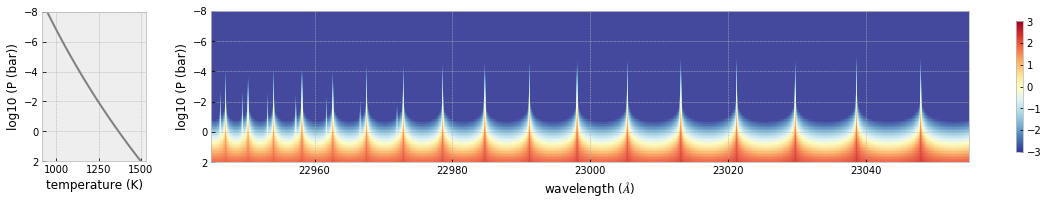

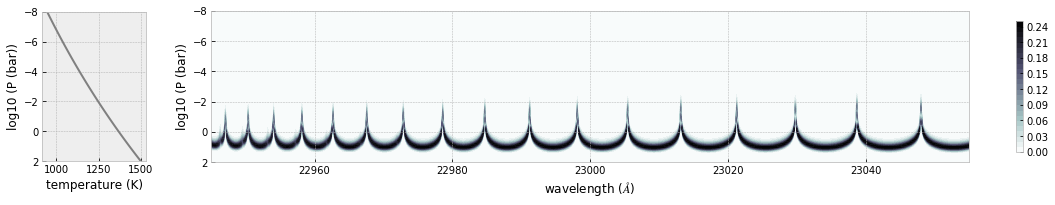

In [35]:
dtauM=dParr[:,None]*xsm*tfac[:,None]
plottau(nus,dtauM,Tarr,Parr,unit="AA") #tau
#plt.savefig("../../documents/figures/plottau.png")
plotcf(nus,dtauM,Tarr,Parr,dParr,unit="AA") 
#plt.savefig("../../documents/figures/plotcf.png")

In [36]:
gi=planck.piBarr(Tarr,nus)

In [37]:
@jit
def rt_twos(xsm,tfac,gi,dParr):
    """Radiative Transfer using 2 stream+AS (Helios-R1 type)
    Args:
        xsm: cross section matrix (cm2)
        tfac: conversion factor pressure x cross section to tau
        gi: blackbody emission layer
        dParr: delta P array
        
    Returns:
        flux in the unit of [erg/cm2/s/Hz]
    """
    Nnus=np.shape(xsm)[1]
    dtauM=dParr[:,None]*xsm*tfac[:,None]
    TransMx=rt.trans2E3(dtauM)
    TransM=jnp.where(dtauM==0, 1.0, TransMx)   
    QN=jnp.zeros(Nnus)
    Qv=(1-TransM)*gi
    Qv=jnp.vstack([Qv,QN])
    onev=jnp.ones(Nnus)
    TransM=jnp.vstack([onev,TransM])
    Fx=(jnp.sum(Qv*jnp.cumprod(TransM,axis=0),axis=0))
    ccgs=29979245800.0 #c (cgs)
    return Fx/ccgs

In [38]:
@jit
def rt_naive(xsm,tfac,gi,dParr):
    """Radiative Transfer without considering mu dependence
    Args:
        xsm: cross section matrix (cm2)
        tfac: conversion factor pressure x cross section to tau
        gi: blackbody emission layer
        dParr: delta P array
        
    Returns:
        flux in the unit of [erg/cm2/s/Hz]
    """
    dtauM=dParr[:,None]*xsm*tfac[:,None]
    tau=jnp.cumsum(dtauM,axis=0)
    Fx=jnp.sum(gi*jnp.exp(-tau)*dtauM,axis=0)
    ccgs=29979245800.0
    return Fx/ccgs

In [39]:
# using scipy E1
from scipy.special import expn
def rt_twos_expn(xsm,tfac,gi,dParr):
    """Radiative Transfer using 2 stream+scipy.special.expn 
    
    Notes:
        This RT uses scipy.special.expn. Hence, JIT does not work. 
        Consider to use rt_twos instead. 
    
    Args:
        xsm: cross section matrix (cm2)
        tfac: conversion factor pressure x cross section to tau
        gi: blackbody emission layer
        dParr: delta P array
        
    Returns:
        flux in the unit of [erg/cm2/s/Hz]
    """   
    Nnus=np.shape(xsm)[1]
    dtauM=dParr[:,None]*xsm*tfac[:,None]
    TransMx=2.0*expn(3,dtauM)
    TransM=jnp.where(dtauM==0, 1.0, TransMx)   
    QN=jnp.zeros(Nnus)
    Qv=(1-TransM)*gi
    
    Qv=jnp.vstack([Qv,QN])
    onev=jnp.ones(Nnus)
    TransM=jnp.vstack([onev,TransM])
    Fx=(jnp.sum(Qv*jnp.cumprod(TransM,axis=0),axis=0))
    ccgs=29979245800.0
    return Fx/ccgs

In [40]:
%timeit Fx0=rt_twos(xsm,tfac,gi,dParr)

207 µs ± 56.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
gie=planck.piBarr(jnp.array([Tarr[-1]]),nus)
gie=planck.piBarr(jnp.array([3000.0]),nus)

In [42]:

@jit
def rt_twos_bottom(xsm,tfac,gi,dParr,gie):
    """Radiative Transfer using 2 stream+AS (Helios-R1 type)
    
    Notes:
       
    Args:
        xsm: cross section matrix (cm2)
        tfac: conversion factor pressure x cross section to tau
        gi: blackbody emission layer
        dParr: delta P array
        gie: bottom layer black body
        
    Returns:
        flux in the unit of [erg/cm2/s/Hz]
    """
    Nnus=np.shape(xsm)[1]
    dtauM=dParr[:,None]*xsm*tfac[:,None]
    TransMx=rt.trans2E3(dtauM)
    TransM=jnp.where(dtauM==0, 1.0, TransMx)   
    QN=gie#jnp.zeros(Nnus)
    Qv=(1-TransM)*gi
    Qv=jnp.vstack([Qv,QN])
    onev=jnp.ones(Nnus)
    TransM=jnp.vstack([onev,TransM])
    Fx=(jnp.sum(Qv*jnp.cumprod(TransM,axis=0),axis=0))
    ccgs=29979245800.0 #c (cgs)
    return Fx/ccgs

In [43]:
from scipy.constants import  m_u
mmw=2.33 #mean molecular weight
molmass=28.01 #molecular mass
mmr=0.001 #mass mixing ratio

g=1.e5 # gravity cm/s2
Xco=np.ones_like(Tarr)*mmr*mmw/molmass 
tfac=1.e3*Xco/(mmw*m_u*g)  

tfac=tfac
#Fx0n=rt_naive(xsm,tfac,gi,dParr)
#dParrM=dParr[:,None]+np.zeros_like(xsm)
Fx0=rtrun(xsm,tfac,gi,dParr)
#Fx0_En=rt_twos_expn(xsm,tfac,gi,dParr)

In [44]:
%timeit Fx0=rt_twos(xsm,tfac,gi,dParr)

116 µs ± 9.58 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [45]:
%timeit Fx0=rtrun(xsm,tfac,gi,dParr)

112 µs ± 2.58 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [46]:
Smax=(np.max(SijM,axis=0))
mask=np.log10(Smax)>-22
len(Smax[mask])

147

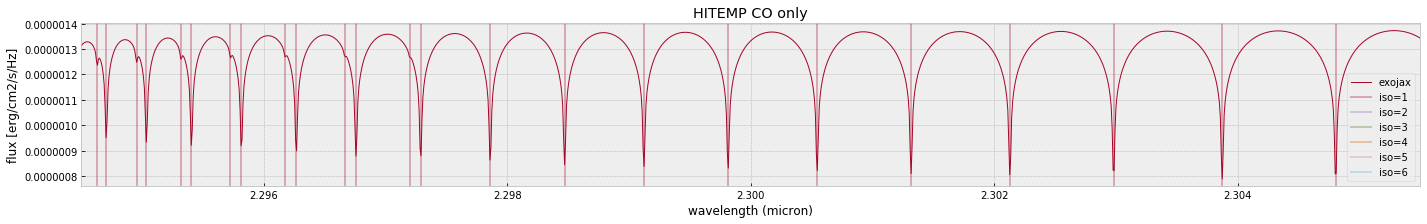

In [49]:
fig=plt.figure(figsize=(24,3))
ax=fig.add_subplot(111)
plt.plot(1.e4/nus,Fx0,lw=1,alpha=1.0,label="exojax",color="C1")
#plt.plot(1.e4/nus,Fx0n,lw=1,alpha=1.0,label="exojax naive",color="C2")
#plt.plot(1.e4/nus,Fx0_En,lw=1,alpha=1.0,label="exojax En",color="C3")
#plt.plot(dat["WAV"],dat["VAL"],lw=1,alpha=0.9,ls="dashed",label="petitRadtran")
### ISO LINE
if True:
    crit=-24
    for iso in mdbCO.uniqiso:
        mask=(mdbCO.isoid==iso)*(np.log10(Smax)>crit)
        wiso=1.e4/nu0[mask]
        for w in wiso:
            plt.axvline(w,color="C"+str(iso),alpha=0.3)

    #iso just for label
    for iso in mdbCO.uniqiso:
        plt.axvline([1.0],color="C"+str(iso),alpha=0.3,label="iso="+str(iso))
###

#plt.xlim(2.38,2.39)
#plt.xlim(2.372,2.385)
plt.xlim(1.e4/nus[-1],1.e4/nus[0])
plt.xlabel("wavelength (micron)")
plt.ylabel("flux [erg/cm2/s/Hz]")
plt.title("HITEMP CO only")
plt.legend()
#plt.savefig("test_CO.png", bbox_inches="tight", pad_inches=0.0)

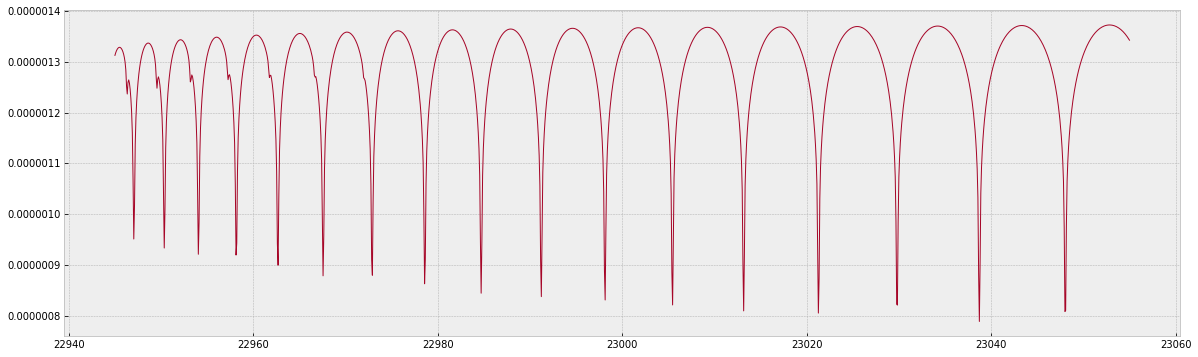

In [50]:
fig=plt.figure(figsize=(20,6.0))

plt.plot(wav[::-1],Fx0,lw=1,color="C1")
plt.savefig("highredCO.png")

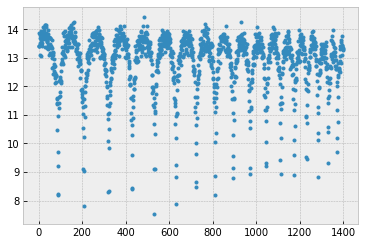

In [52]:
intfac=1.e7
sigin=0.25
N=len(Fx0)
data=Fx0*intfac+np.random.normal(0,sigin,size=N)
plt.plot(data,".")

In [53]:
vgamma_hitran=jit(vmap(gamma_hitran,(0,0,0,None,None,None)))
vdoppler_sigma=jit(vmap(doppler_sigma,(None,0,None)))
vSij=jit(vmap(SijT,(0,None,None,None,0)))

In [54]:
import arviz
import numpyro.distributions as dist
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi

/home/kawahara/anaconda3/lib/python3.7/site-packages/distributed/utils.py:139: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [55]:
    A0=-0.57721566
    A1= 0.99999193
    A2=-0.24991055
    A3= 0.05519968
    A4=-0.00976004
    A5= 0.00107857
    B1=8.5733287401
    B2=18.059016973
    B3=8.6347608925
    B4=0.2677737343
    C1=9.5733223454
    C2=25.6329561486
    C3=21.0996530827
    C4=3.9584969228

In [56]:
#dParr[:,None]+np.zeros(np.shape(xsm))

In [57]:
#send molecular database to device
device_gamma_natural=jnp.array(gamma_natural(mdbCO.A))
device_logsij=jnp.array(mdbCO.logsij0)
device_nu_lines=jnp.array(mdbCO.nu_lines)
device_elower=jnp.array(mdbCO.elower)
device_n_air=jnp.array(mdbCO.n_air)
device_gamma_air=jnp.array(mdbCO.gamma_air)
device_gamma_self=jnp.array(mdbCO.gamma_self)
device_relative_Parr=jnp.array(Parr/Parr[-1])
device_Parr=jnp.array(Parr)
device_dParr=jnp.array(dParr[:,None]+np.zeros(np.shape(xsm)))
device_zerov=jnp.zeros(len(nus))
device_onev=jnp.ones(len(nus))

In [58]:
#epsilon=1.e-20
#ccgs=29979245800.0 
#intfaccgs=intfac/ccgs

def model(nu,y):
    A = numpyro.sample('A', dist.Uniform(0.5,1.5))
    sigma = numpyro.sample('sigma', dist.Exponential(0.3))
    #T0 = numpyro.sample('T0', dist.Uniform(1400,1600))
    nu0 = numpyro.sample('nu0', dist.Uniform(-0.3,0.3))
    #alpha=0.02 
    alpha = numpyro.sample('alpha', dist.Uniform(0.019,0.021))

    #T-P model
    Tarr = 1500.*(device_relative_Parr)**alpha 
    
    #line computation
    SijM=vSij(Tarr,device_logsij,device_nu_lines,device_elower,qt)
    gammaLM = vgamma_hitran(device_Parr,Tarr,device_Parr,\
                            device_n_air, device_gamma_air, device_gamma_self) \
                            + device_gamma_natural 
    sigmaDM=vdoppler_sigma(device_nu_lines,Tarr,molmass)
    gi = planck.piBarr(Tarr,nus)
    xsm=cxsmatrix(numatrix-nu0,sigmaDM,gammaLM,SijM)    
    mu=rtrun(xsm,tfac,gi,dParr)
    mu=intfac*A*mu
    numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

In [59]:
#nus, numatrix0 -> device?

In [60]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 100, 200

#kernel = NUTS(model)
kernel = NUTS(model,forward_mode_differentiation=True)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, nu=nus, y=data)
mcmc.print_summary()

sample: 100%|██████████| 300/300 [1:02:02<00:00,  8.15s/it, 47 steps of size 2.03e-02. acc. prob=0.96] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         A      1.00      0.00      1.00      1.00      1.00     31.52      1.00
     alpha      0.02      0.00      0.02      0.02      0.02     31.05      1.00
       nu0     -0.00      0.00     -0.00     -0.00      0.00    142.22      1.00
     sigma      0.25      0.01      0.25      0.24      0.26    130.14      1.02

Number of divergences: 0


In [61]:
posterior_sample = mcmc.get_samples()
pred = Predictive(model,posterior_sample)
nu_ = nus
predictions = pred(rng_key_,nu=nu_,y=None)
median_mu = jnp.median(predictions["y"],axis=0)

In [62]:
hpdi_mu = hpdi(predictions["y"], 0.9)

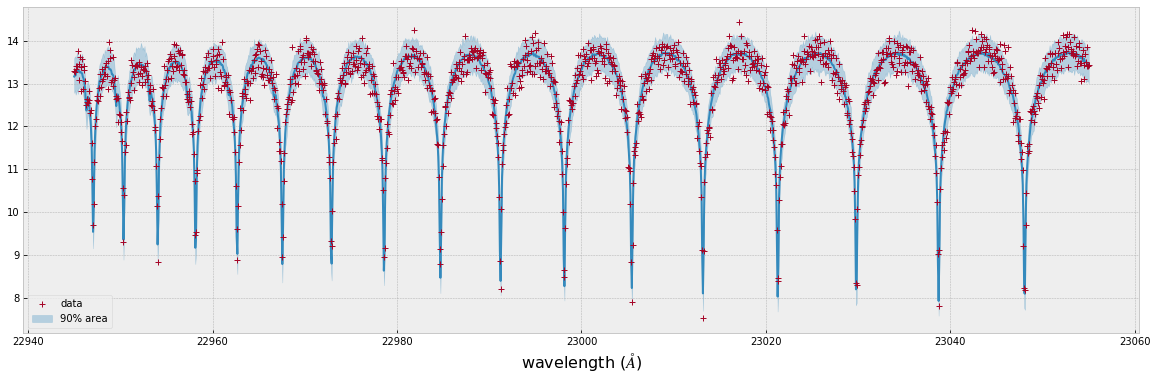

In [63]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,6.0))


#plt.plot(wav[::-1],Fx0,lw=1,color="C1",label="in")
ax.plot(wav[::-1],median_mu,color="C0")
ax.plot(wav[::-1],data,"+",color="C1",label="data")
ax.fill_between(wav[::-1], hpdi_mu[0], hpdi_mu[1], alpha=0.3, interpolate=True,color="C0",
                label="90% area")
plt.xlabel("wavelength ($\AA$)",fontsize=16)
plt.legend()
plt.savefig("../../documents/figures/mcmc_fitting_CO_emission.png")
plt.show()

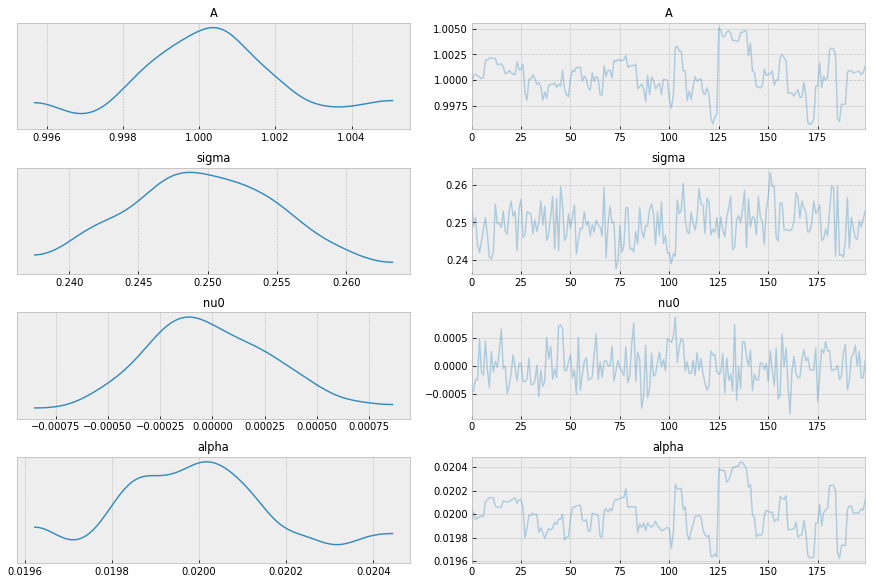

In [64]:
import arviz
arviz.plot_trace(mcmc, var_names=["A","sigma","nu0","alpha"])
plt.show()

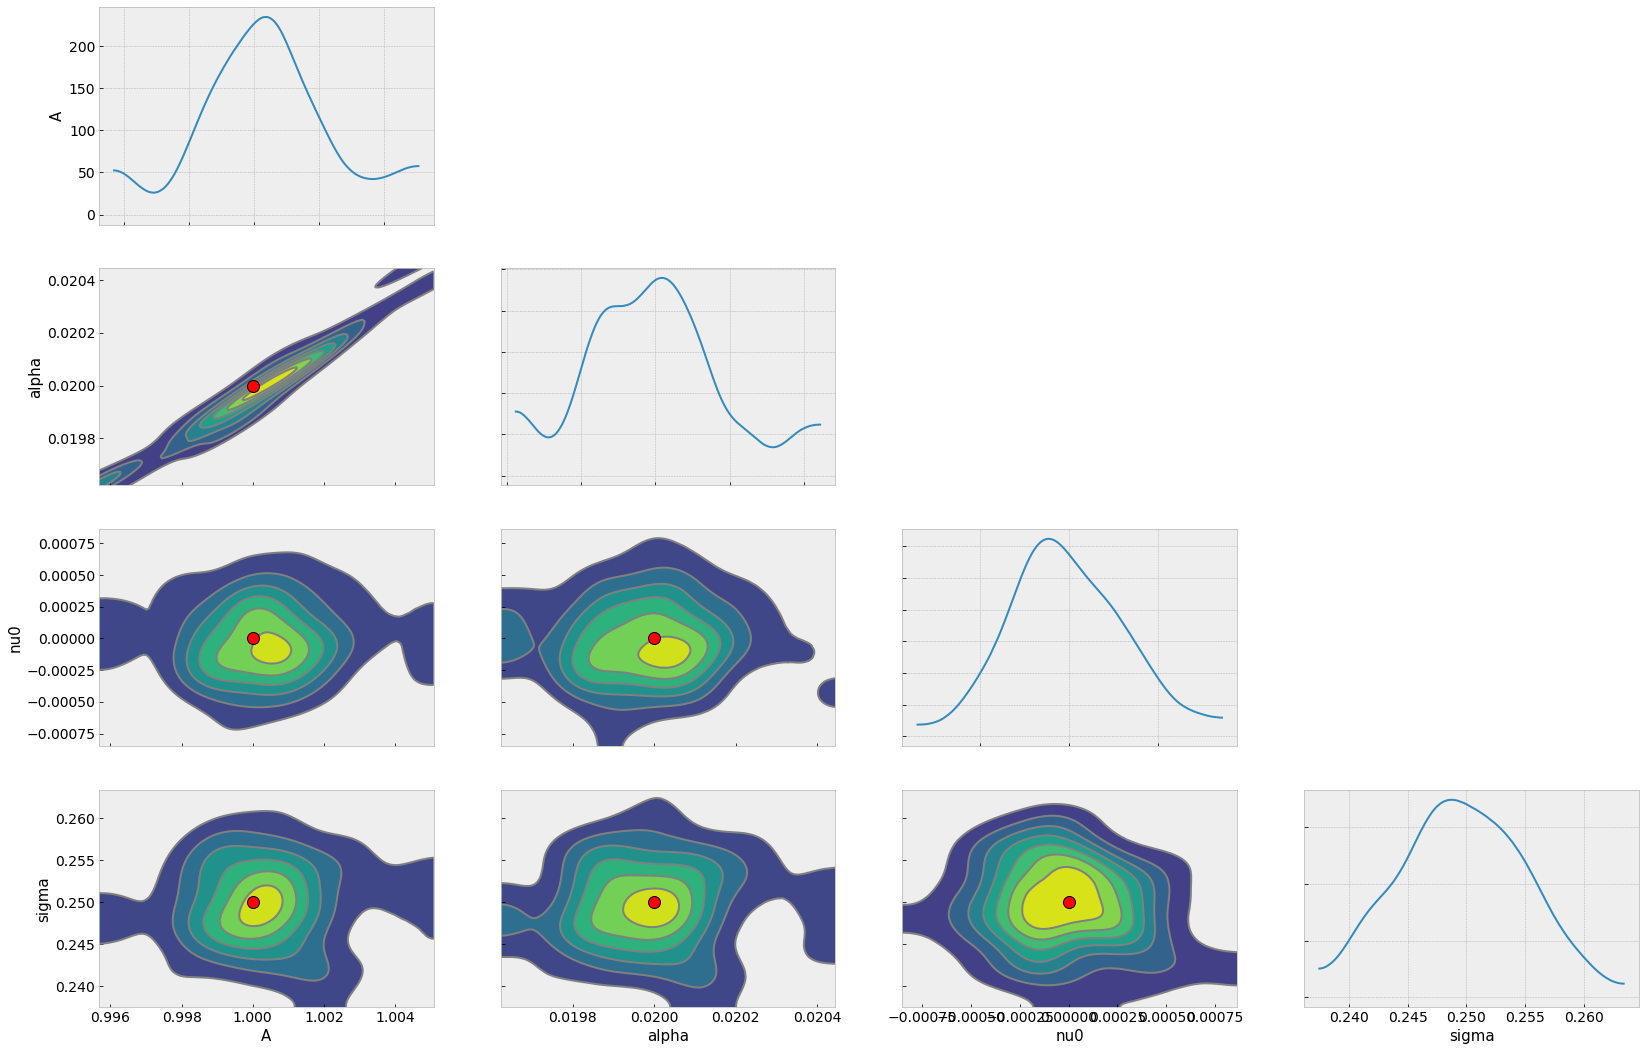

In [66]:
refs={}
refs["A"]=1.0
#refs["sD"]=sDfix
#refs["gL"]=gLfix
refs["sigma"]=sigin
refs["nu0"]=0.0
refs["alpha"]=0.02
#refs["alpha"]=-0.1
arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',divergences=False,\
                marginals=True,
                reference_values=refs,
               reference_values_kwargs={'color':"red", "marker":"o", "markersize":12}) 
plt.savefig("../../documents/figures/posterior_CO.png")
plt.show()

In [ ]:
sigin

In [67]:
len(device_nu_lines)

771